**Description**

This file attempts to summarize and only keep relevant production level plots that are useful, cleaning up the plots

representation_heatmaps.ipynb
* This file did a lot of exploration with activations. Most importantly discovered that nodes can exhibit hallucinations
* Also determined that it should be valid to collect activations on off-policy trajectories, so for clean clustering we use conserved direct pathways

representation_heatmaps2.ipynb
* **Note that a lot of important data generation code is in this file, in Section 1**
* In this file we actually generate the conserved trajectories taken from our best 64 width network agents


In [2]:
from tqdm import tqdm
%run model_evaluation
import torch
from torch import nn, optim
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import defaultdict

import matplotlib.pyplot as plt
import proplot as pplt
import umap
import pandas as pd

# model, obs_rms, kwargs = load_model_and_env('nav_auxiliary_tasks/nav_aux_wall_1', 0)
# env = gym.make('NavEnv-v0', **kwargs)

save = 'plots/representation_heatmaps/'

%run representation_analysis
%run model_evaluation


def gaussian_smooth(pos, y, extent=(5, 295), num_grid=30, sigma=10,
                    ret_hasval=False):
    # a = stacked['shared_activations'][0, :, 0].numpy()
    y = np.array(y)
    
    grid = np.linspace(extent[0], extent[1], num_grid)
    xs, ys = np.meshgrid(grid, grid)
    ys = ys[::-1]
    smoothed = np.zeros(xs.shape)
    hasval = np.zeros(xs.shape)
    for i in range(num_grid):
        for j in range(num_grid):
            p = np.array([xs[i, j], ys[i, j]])
            dists = np.sqrt(np.sum((pos - p)**2, axis=1))
            g = np.exp(-dists**2 / (2*sigma**2))
            
            if len(g[g > 0.1]) < 1:
                val = 0
            else:
                val = np.sum(y[g > 0.1] * g[g > 0.1]) / np.sum(g[g > 0.1])
                hasval[i, j] = 1

            smoothed[i, j] = val
    if ret_hasval:
        return smoothed, hasval
    else:
        return smoothed


def clean_eps(eps, prune_first=5, activations_key='shared_activations',
             activations_layer=0, clip=False,
             save_inview=True, save_seen=True):
    '''Clean up an eps data dictionary collected from evalu for heatmapping'''
    dones = eps['dones'].copy()
    pos = np.vstack(eps['data']['pos'])
    stacked = stack_activations(eps['activations'])
    angles = eps['data']['angle']
    acts = eps['actions']
    
    activ = stacked[activations_key][activations_layer, :, :].numpy()
    pinview = np.array(eps['data']['poster_in_view'])
    pseen = np.array(eps['data']['poster_seen'])
    
    ep_activ = split_by_ep(activ, dones)
    ep_pos = split_by_ep(pos, dones)
    ep_pinview = split_by_ep(pinview, dones)
    ep_angle = split_by_ep(angles, dones)
    ep_pseen = split_by_ep(pseen, dones)
    ep_acts = split_by_ep(acts, dones)
    
    if prune_first and prune_first > 0:
        prune_first = 5
        pruned_ep_activ = [a[prune_first:] for a in ep_activ]
        pruned_activ = np.vstack(pruned_ep_activ)
        pruned_ep_pos = [p[prune_first:] for p in ep_pos]
        pruned_pos = np.vstack(pruned_ep_pos)
        pruned_ep_pinview = [p[prune_first:] for p in ep_pinview]
        pruned_pinview = np.concatenate(pruned_ep_pinview)
        pruned_ep_angles = [p[prune_first:] for p in ep_angle]
        pruned_angles = np.concatenate(pruned_ep_angles)
        pruned_ep_pseen = [p[prune_first:] for p in ep_pseen]
        pruned_pseen = np.concatenate(pruned_ep_pseen)
        pruned_ep_acts = [p[prune_first:] for p in ep_acts]
        pruned_acts = np.concatenate(pruned_ep_acts)
        
        pos = pruned_pos
        activ = pruned_activ
        pinview = pruned_pinview
        angles = pruned_angles
        pseen = pruned_pseen
        acts = pruned_acts
    
    if clip:
        activ = np.clip(activ, 0, 1)
    
    result_dict = {
        'pos': pos,
        'activ': activ,
        'pinview': pinview,
        'pseen': pseen,
        'angles': angles,
        'dones': dones,
        'actions': acts
    }
    
    if save_inview:
        result_dict.update({
            'pos_inview': pos[pinview],
            'pos_notinview': pos[~pinview],
            'activ_inview': activ[pinview],
            'activ_notinview': activ[~pinview],
            'angles_inview': angles[pinview],
            'angles_notinview': angles[~pinview],
        })
    if save_seen:
        result_dict.update({'pos_seen': pos[pseen],
        'pos_notseen': pos[~pseen],
        'activ_seen': activ[pseen],
        'activ_notseen': activ[~pseen],
        'angles_seen': angles[pseen],
        'angles_notseen': angles[~pseen],
        })
    
    return result_dict
    
    
def stack_all_ep(all_ep):
    '''
    When making a list of results from multiple evalu calls,
    this function can be called to put the relevant data into a single dict to be
    passed to clean_eps for processing
    '''
    dones = np.concatenate([ep['dones'] for ep in all_ep])
    pos = np.vstack([ep['data']['pos'] for ep in all_ep])
    angles = np.concatenate([ep['data']['angle'] for ep in all_ep])
    pseen = np.concatenate([ep['data']['poster_seen'] for ep in all_ep])
    pinview = np.concatenate([ep['data']['poster_in_view'] for ep in all_ep])
    actions = np.vstack([np.vstack(ep['actions']) for ep in all_ep]).squeeze()
    activations = []
    for ep in all_ep:
        activations += ep['activations']

    eps = {
        'dones': dones,
        'activations': activations,
        'actions': actions,
        'data': {
            'pos': pos,
            'angle': angles,
            'poster_seen': pseen,
            'poster_in_view': pinview
        }
    }
    return eps
    

    
def split_by_angle(target, angles):
    splits = {
        0: [-np.pi/4, np.pi/4],
        1: [np.pi/4, 3*np.pi/4],
        3: [-3*np.pi/4, -np.pi/4],
        2: None #this will use else statement otherwise bounds are annoying
    }
    all_trues = np.zeros(angles.shape) == 1
    result = {}
    
    for s in [0, 1, 3]:
        split = splits[s]
        split_idxs = (split[0] <= angles) & (angles <= split[1])
        all_trues = all_trues | split_idxs
        
        result[s] = target[split_idxs]
    #finally, the ones that didn't fit into any of the other quadrants
    result[2] = target[~all_trues]
    
    return result
    
        
    
def compute_directness(all_ep=None, ep=None, pos=None):
    '''
    Compute the directness of paths taken either from an all_ep (split up
    eps generated from appending evalu() calls) or from a single ep
    '''
    goal_loc = np.array([250, 70])
    if all_ep is None and ep is None and pos is None:
        raise Exception('No proper parameters given')

    if all_ep is not None:
        directnesses = []
        for i in range(len(all_ep)):
            p = np.vstack(all_ep[i]['data']['pos'])
            d = p - goal_loc
            d = np.sqrt(np.sum(d**2, axis=1))
            dist_changes = np.diff(d)
            directness = np.sum(dist_changes[:-1] < 0) / np.sum(dist_changes[:-1] != 0)
            directnesses.append(directness)
        return np.array(directnesses)
    else:
        if ep is not None:
            p = np.vstack(ep['data']['pos'])
        elif pos is not None:
            p = pos
        d = p - goal_loc
        d = np.sqrt(np.sum(d**2, axis=1))
        dist_changes = np.diff(d)
        directness = np.sum(dist_changes[:-1] < 0) / np.sum(dist_changes[:-1] != 0)
        return directness
    
        
            
            
def filter_all_ep_directness(all_ep, bound=0.9):
    d = compute_directness(all_ep)
    idxs = d > 0.9
    d_ep = [ep for i, ep in enumerate(all_ep) if idxs[i]]
    return d_ep



def load_heatmaps(file='data/pdistal_rim_heatmap/rim_heatmaps'):
    all_heatmaps = pickle.load(open(file, 'rb'))

    heatmaps = []
    heatmap_idx_to_model = []
    heatmap_model_to_idxs = {}
    widths = [4, 8, 16, 32, 64]
    trials = 3

    current_idx = 0
    for width in widths:
        heatmap_model_to_idxs[width] = []
        for trial in range(trials):
            heatmaps.append(all_heatmaps[width][trial])

            #create indexers to map back and forth between heatmap idxs and models
            for i in range(width):
                heatmap_idx_to_model.append([width, trial, i])
            heatmap_model_to_idxs[width].append([current_idx, current_idx+width])
            current_idx = current_idx + width

    heatmaps = np.clip(np.vstack(heatmaps).reshape(372, 900), 0, 1)
    return heatmaps, heatmap_idx_to_model, heatmap_model_to_idxs


def count_labels(clabels, ignore_cluster=None, remove_zeros=False):
    #Convert a list of cluster labels into ratios
    cluster_counts = np.zeros(num_clusters)
    for i in range(num_clusters):
        cluster_counts[i] = np.sum(clabels == i)
        
    if ignore_cluster is not None:
        if type(ignore_cluster) == list:
            for c in ignore_cluster:
                cluster_counts[c] = 0
        elif type(ignore_cluster) == int:
            cluster_counts[ignore_cluster] = 0
    
    cluster_ratios = cluster_counts / np.sum(cluster_counts)
    
    if remove_zeros:
        cluster_ratios = cluster_ratios[cluster_ratios != 0]
        cluster_counts = cluster_counts[cluster_counts != 0]
    return cluster_counts, cluster_ratios



def pred_kmeans(heatmaps, kmeans):
    '''
    Given a list of heatmaps, perform necessary reshaping and predict cluster with kmeans
    '''
    hms = np.vstack([hm.reshape(1, -1) for hm in heatmaps])
    labels = kmeans.predict(hms)
    return labels

# Clustering

## Agglomerative Clustering

We visualize agglomerative clustering for validation that our number of clusters makes sense (9 clusters seems valid)

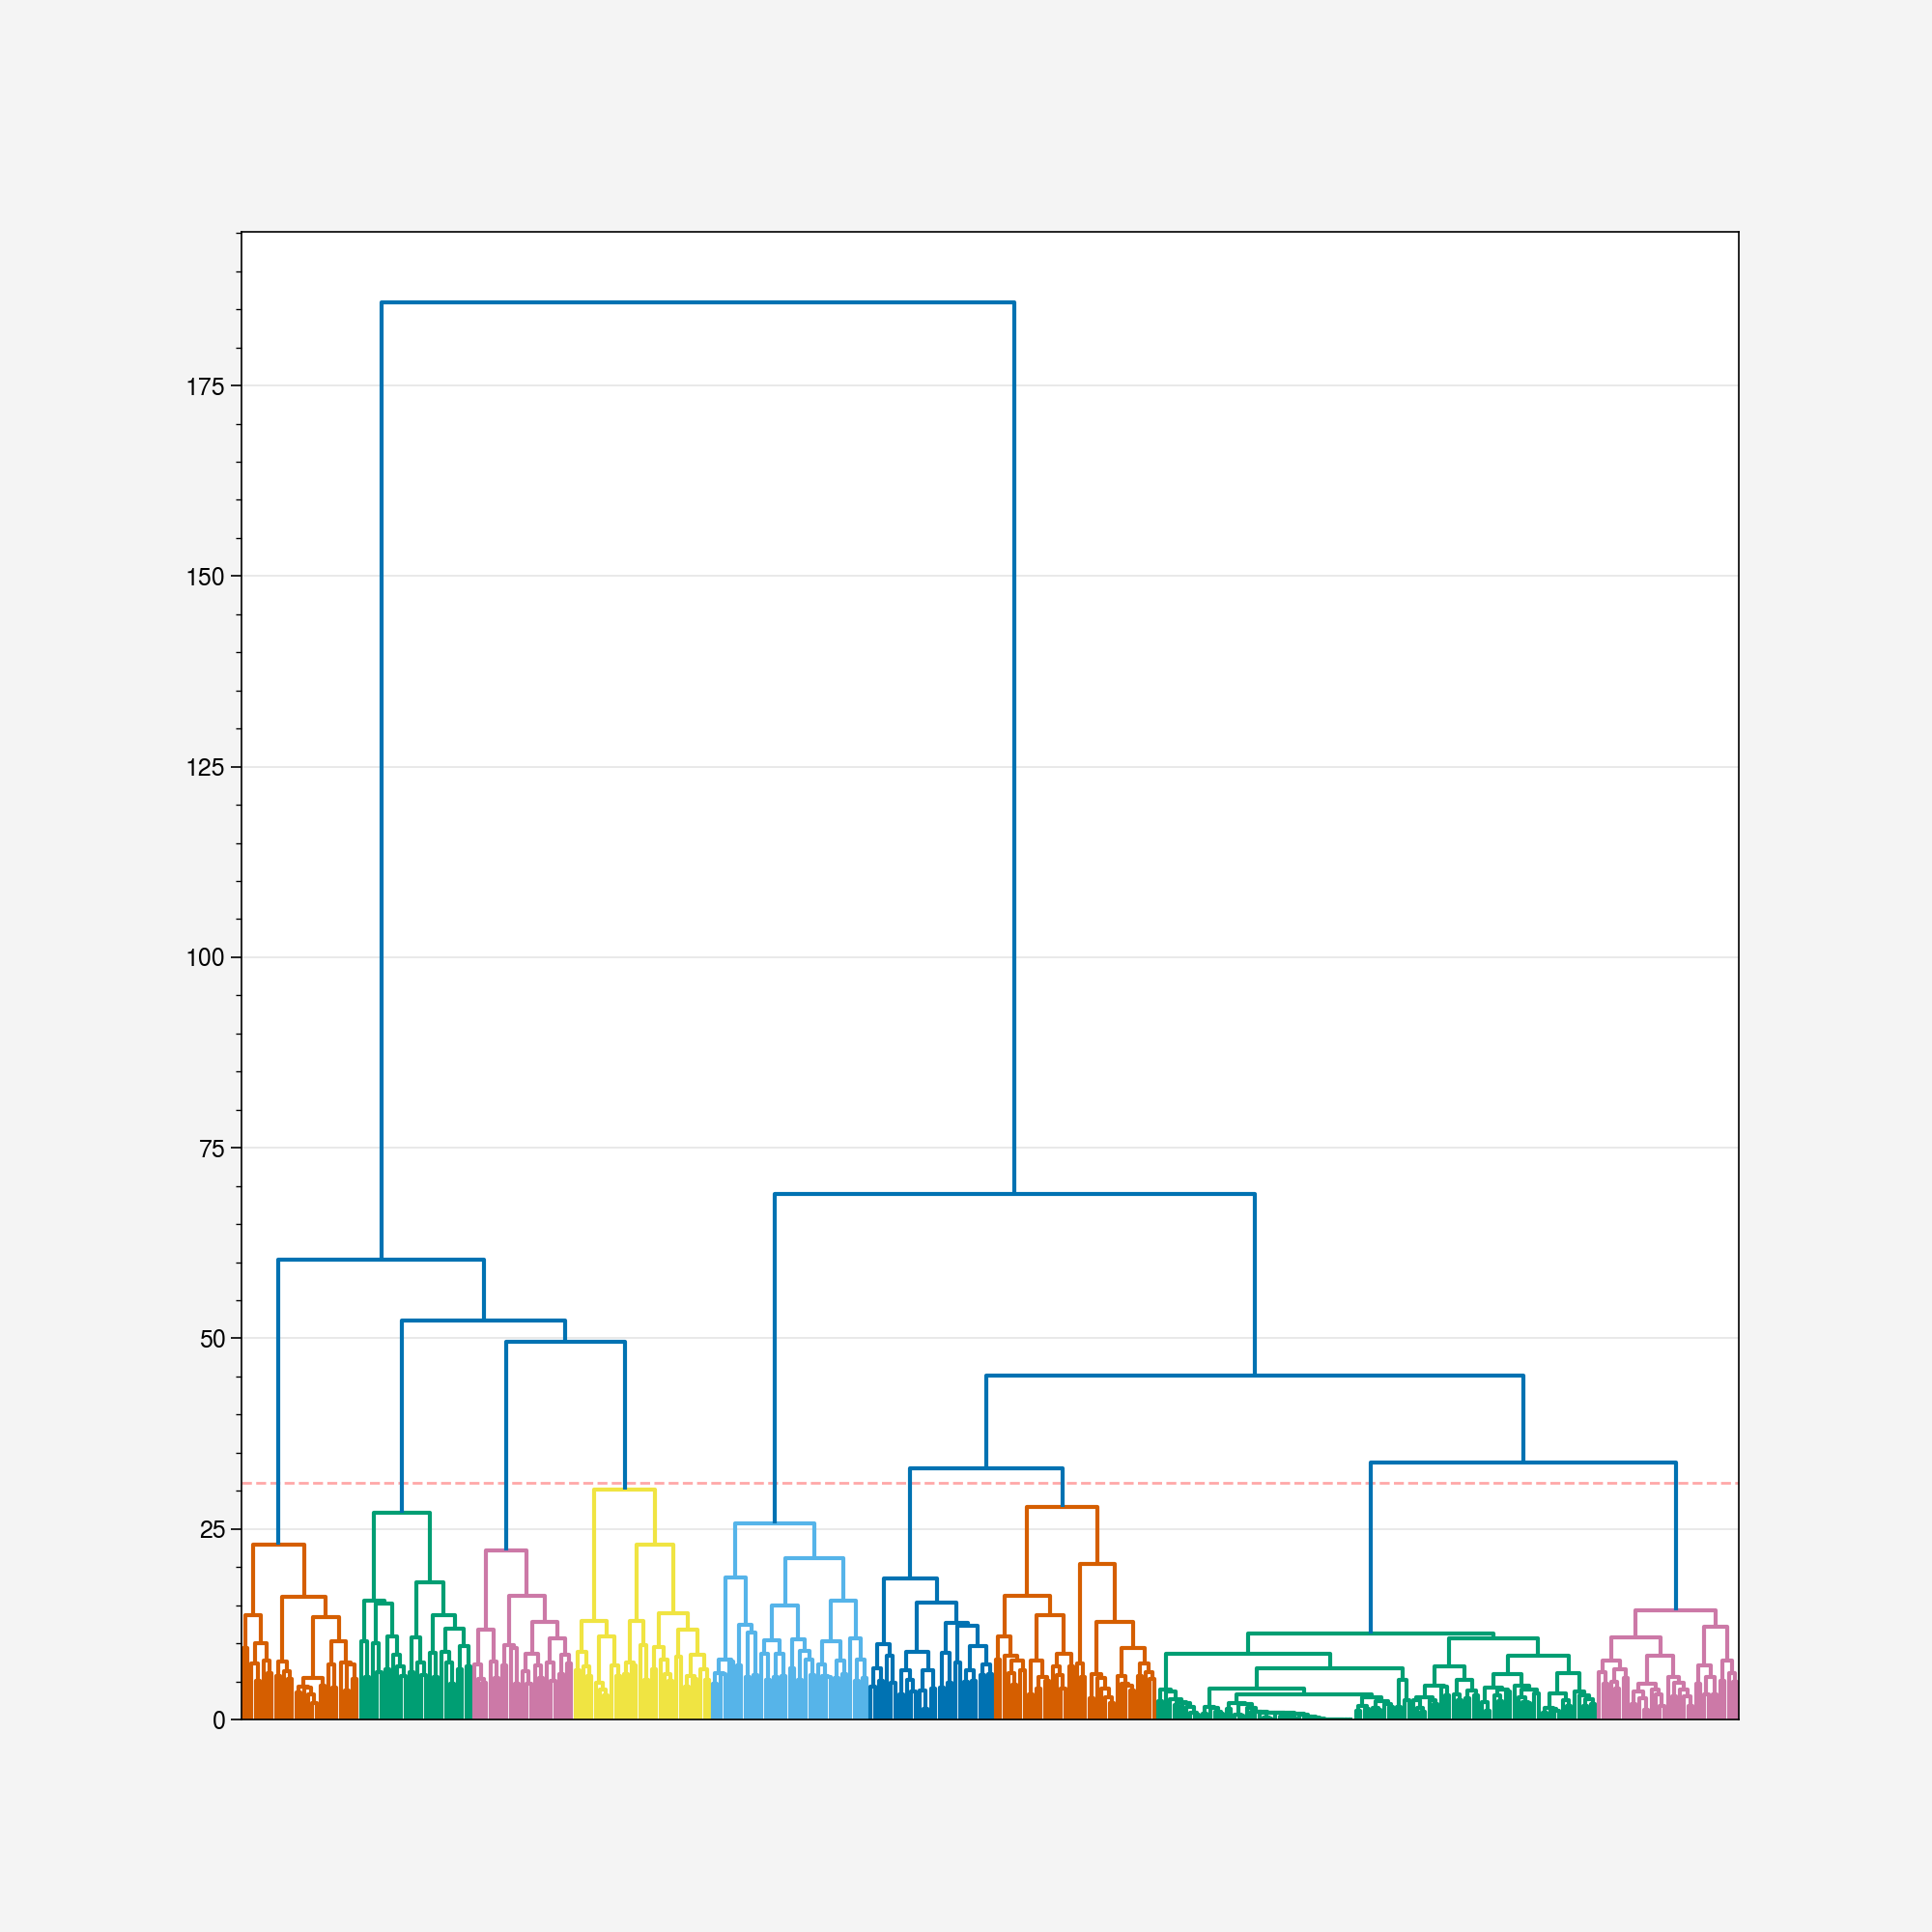

In [3]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

heatmaps, heatmap_idx_to_model, heatmap_model_to_idxs = load_heatmaps()


def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    
    for i, merge in  enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    
    dendrogram(linkage_matrix, **kwargs)

distance_threshold = 31

model = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=None)
preds = model.fit_predict(heatmaps)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xticks([])
ax.plot([0, 3700], [distance_threshold, distance_threshold], '--', c='red3', linewidth=1)
plot_dendrogram(model, truncate_mode='level', ax=ax, 
                color_threshold=distance_threshold, no_labels=True)


num_clusters = int(np.max(preds) + 1)
cluster_idxs = []
for i in range(num_clusters):
    cluster_idxs.append(preds == i)
    
plt.savefig(save + '1_1_2_agglomerative_dendrogram.png')


## KMeans

We already generated the KMeans clustering model in *representationn_heatmaps2.ipynb* and this section allows for visualizing of the clusters if necessary

<BarContainer object of 9 artists>

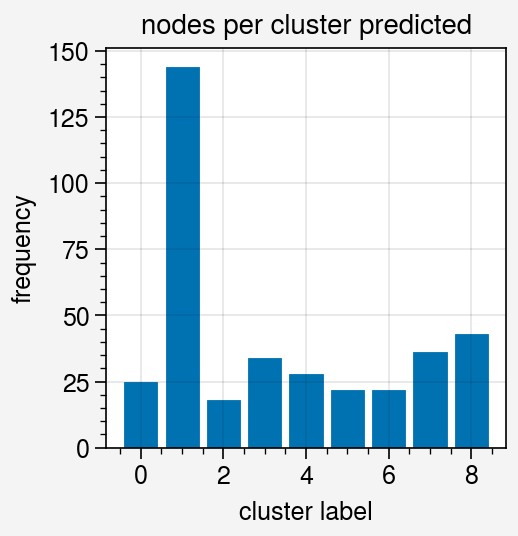

In [5]:
heatmaps, _, _ = load_heatmaps()
kmeans = pickle.load(open('data/pdistal_rim_heatmap/kmeans_heatmap_clusterer', 'rb'))
preds = kmeans.predict(heatmaps)
cluster_idxs = []
for i in range(9):
    cluster_idxs.append(preds == i)

fig, ax = pplt.subplots(refwidth=2)
ax.format(ylabel='frequency', xlabel='cluster label', title='nodes per cluster predicted')
ax.bar(np.arange(9), [cluster.sum() for cluster in cluster_idxs])


In [ ]:
cluster = 0
ph = heatmaps[cluster_idxs[cluster], :].reshape(-1, 30, 30)
num_heatmaps = ph.shape[0]
nrows = int(np.ceil(np.sqrt(num_heatmaps)))
ncols = int(np.ceil(np.sqrt(num_heatmaps)))
if ncols*(nrows-1) >= ph.shape[0]:
    nrows = nrows-1

fig, ax = pplt.subplots(nrows=nrows, ncols=ncols)
for i in range(ph.shape[0]):
    ax[i].imshow(ph[i], extent=(5, 295, 5, 295))

## Clustering vs. Natural Policy Trajectories

One of the clearest visualizations is that availability of nodes with certain clusters in an agent seem to affect its actually behavior

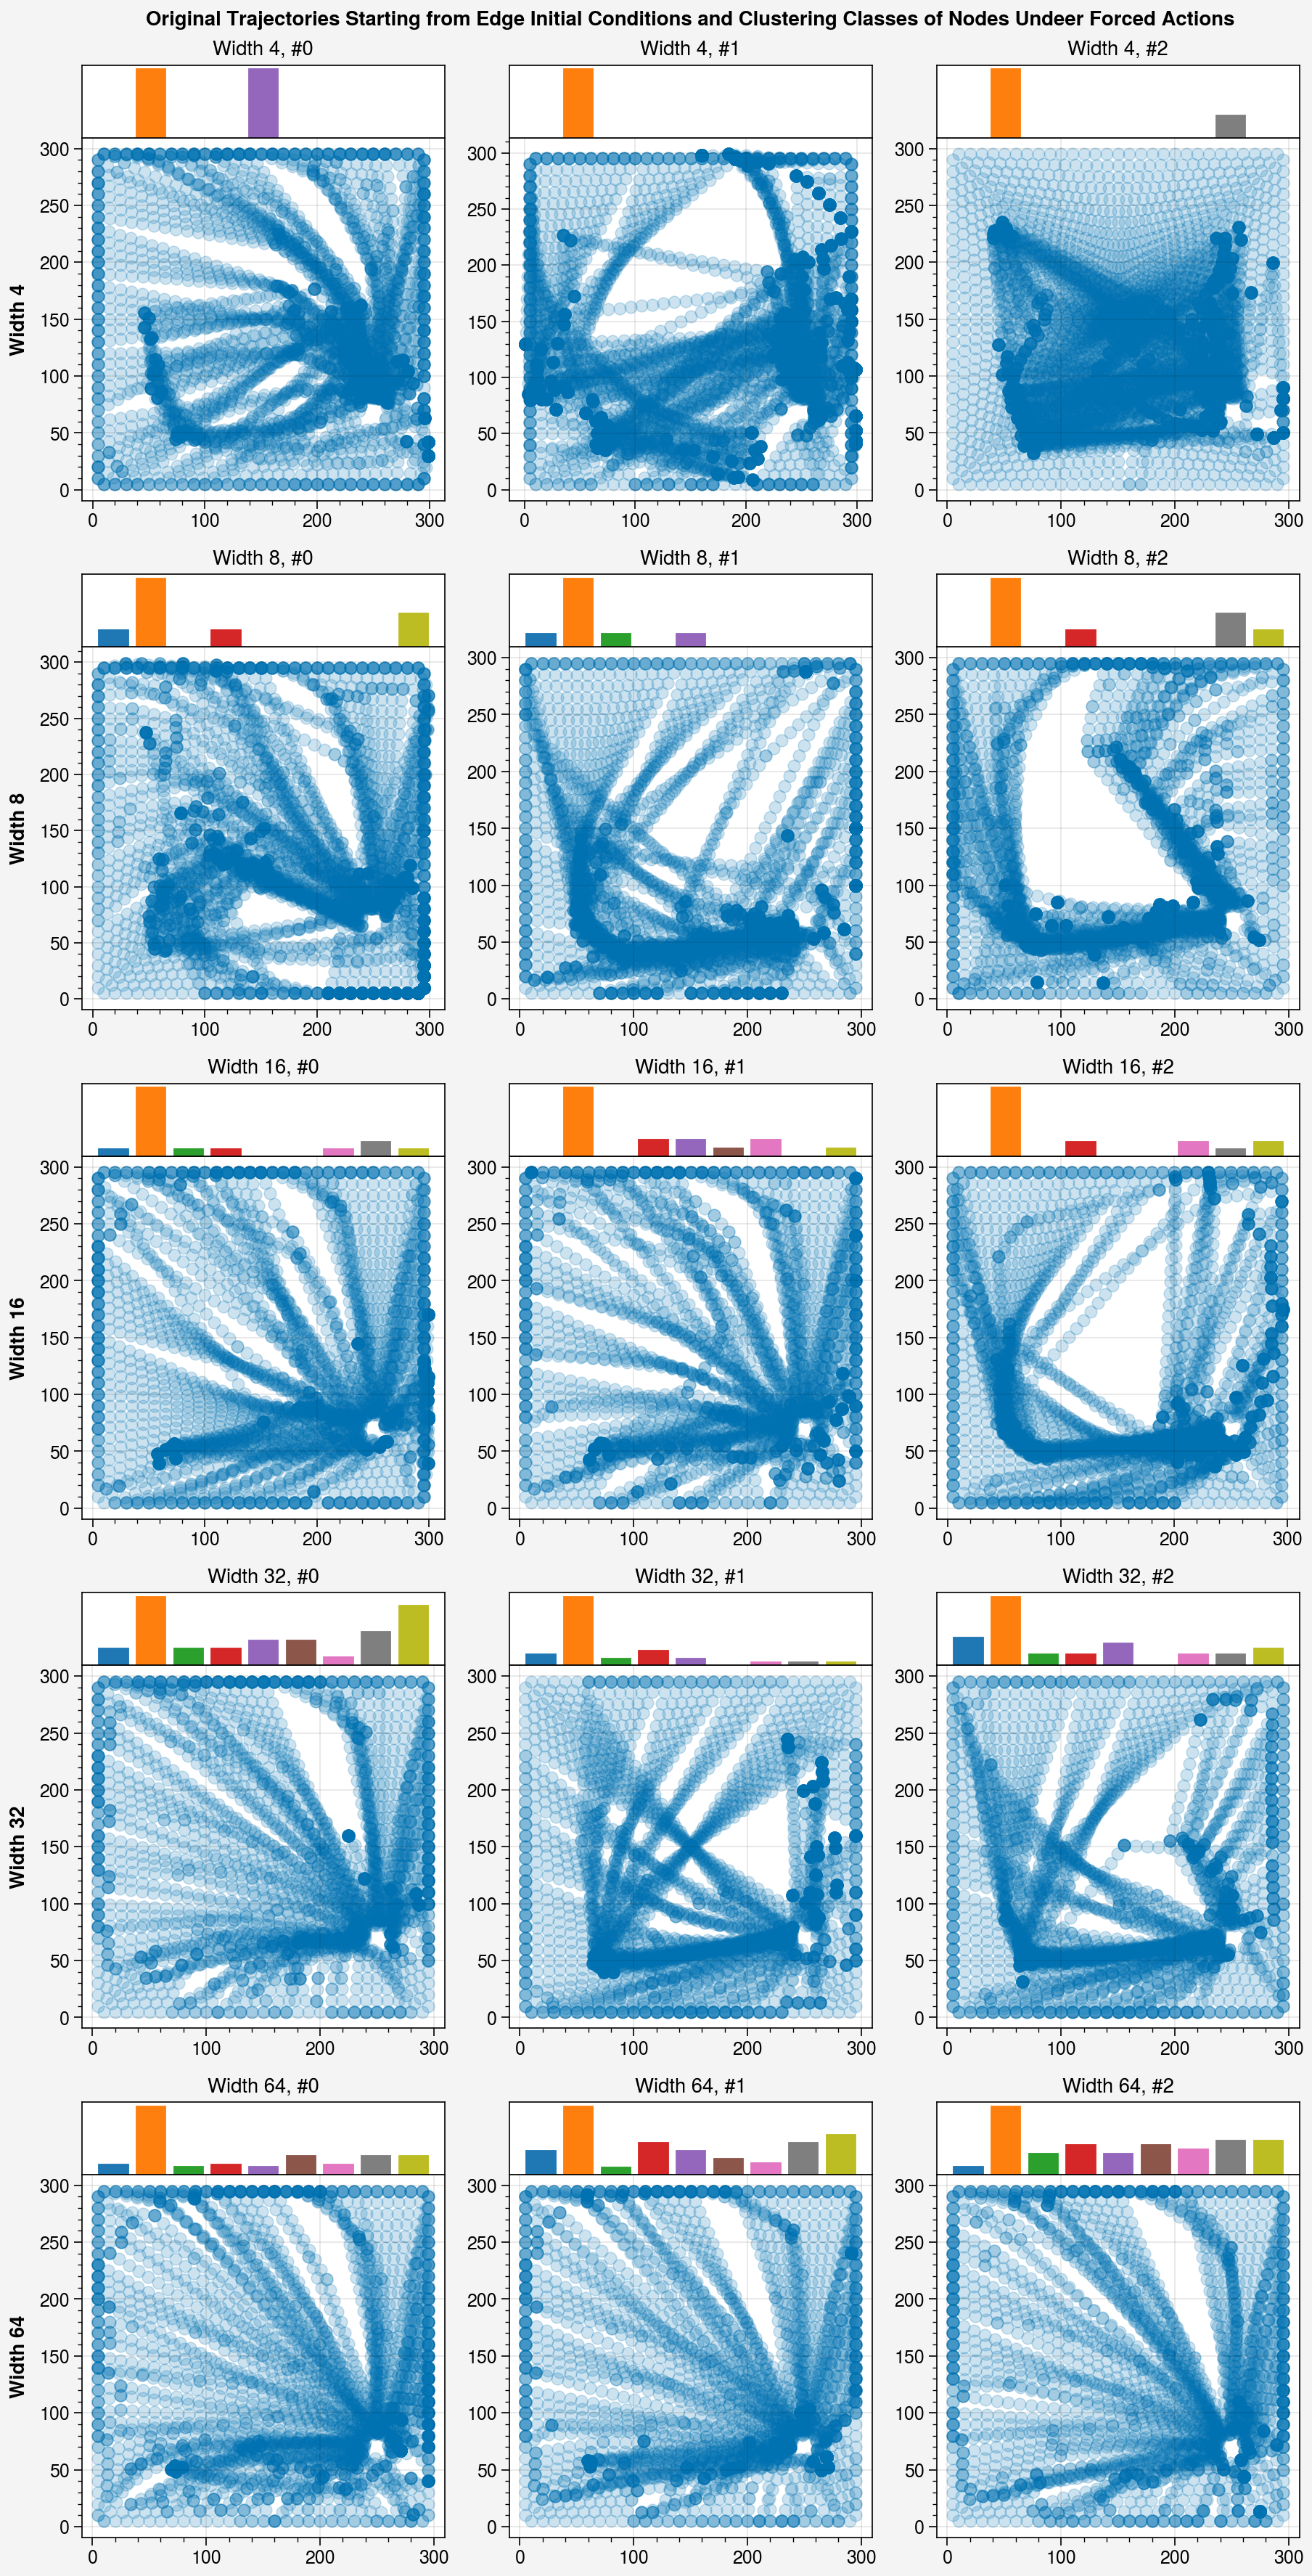

In [9]:
heatmaps, heatmap_idx_to_model, heatmap_model_to_idxs = load_heatmaps()


def convert_labels_to_bar(labels, num_classes=9):
    heights = []
    
    for i in range(num_classes):
        heights.append(np.sum(labels == i))
        
    return np.array(heights)

widths = [4, 8, 16, 32, 64]
# widths = [4]
trials = 3

fig, ax = pplt.subplots(nrows=len(widths), ncols=trials, share=False)
taxs = ax.panel('t', space=0, share=False)

colors = pplt.Cycle('default').by_key()['color']
hex_to_rgb = lambda h: tuple(int(h.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
rgb_colors = np.array([hex_to_rgb(color) for color in colors])/255

titles = []

ax_idx = 0
for width in widths:
    eps = pickle.load(open(f'data/pdistal_rim_heatmap/width{width}', 'rb'))

    for trial in range(trials):
        ep = eps[trial]
        p = ep['pos']
        
        heatmap_idxs = heatmap_model_to_idxs[width][trial]
        
        labels = preds[heatmap_idxs[0]:heatmap_idxs[1]]
        
        ax[ax_idx].scatter(p.T[0], p.T[1], alpha=0.2)
        taxs[ax_idx].bar(convert_labels_to_bar(labels), colors=rgb_colors)
        
        titles.append(f'Width {width}, #{trial}')
        ax_idx += 1
                      
ax.format(title=titles, leftlabels=[f'Width {width}' for width in widths],
         suptitle='Original Trajectories Starting from Edge Initial Conditions and Clustering Classes of Nodes Undeer Forced Actions')
taxs.format(xlocator=[], ylocator=[])
fig.save(save + '1_1_3_trajectories_and_classes.png')

# Summary Statistics

In [11]:
'''
Newer code with dictionary entries
'''

heatmaps, heatmap_idx_to_model, heatmap_model_to_idxs = load_heatmaps()
kmeans = pickle.load(open('data/pdistal_rim_heatmap/kmeans_heatmap_clusterer', 'rb'))

num_clusters = 9
widths = [2, 3, 4, 8, 16, 32, 64]
trials = 10

# Summarize clustering and behavior statistics
all_heatmaps = pickle.load(open('data/pdistal_rim_heatmap/rim_heatmaps', 'rb'))
results = {}
for width in widths:
    results[width] = []
    all_eps = pickle.load(open(f'data/pdistal_rim_heatmap/width{width}', 'rb'))
    for trial in range(trials):
        eps = all_eps[trial]
        directness = compute_directness(pos=eps['pos'])
        
        ep_dones = split_by_ep(eps['dones'], eps['dones'])
        ep_lens = np.array([ep.shape[0] for ep in ep_dones])
        success_rate = 1 - np.sum(ep_lens == 202) / len(ep_lens)
        average_ep_len = np.mean(ep_lens)
        average_succ_ep_len = np.mean(ep_lens[ep_lens < 202])
        
        acts = eps['actions']
        act_ratios = np.array([np.sum(acts == i) for i in range(4)]) / len(acts)
        
        hms = np.vstack([hm.reshape(1, -1) for hm in all_heatmaps[width][trial]])
        labels = kmeans.predict(hms)
        _, ratios = count_labels(labels, remove_zeros=False)
        _, nonzero = count_labels(labels, remove_zeros=True)
        hprime = np.sum(-nonzero * np.log(nonzero))        

        
        
        results[width].append({
            'cluster_labels': labels, 
            'cluster_ratios': ratios, 
            'directness': directness, 
            'success_rate': success_rate, 
            'avg_ep_len': average_ep_len, 
            'avg_succ_ep_len': average_succ_ep_len, 
            'act_ratios': act_ratios,
            'shannon': hprime
        })
        

## Shannon-Wiener

The Shannon-Wiener index gives a measure of effective richness which combines number of species with how well spread number of each species are

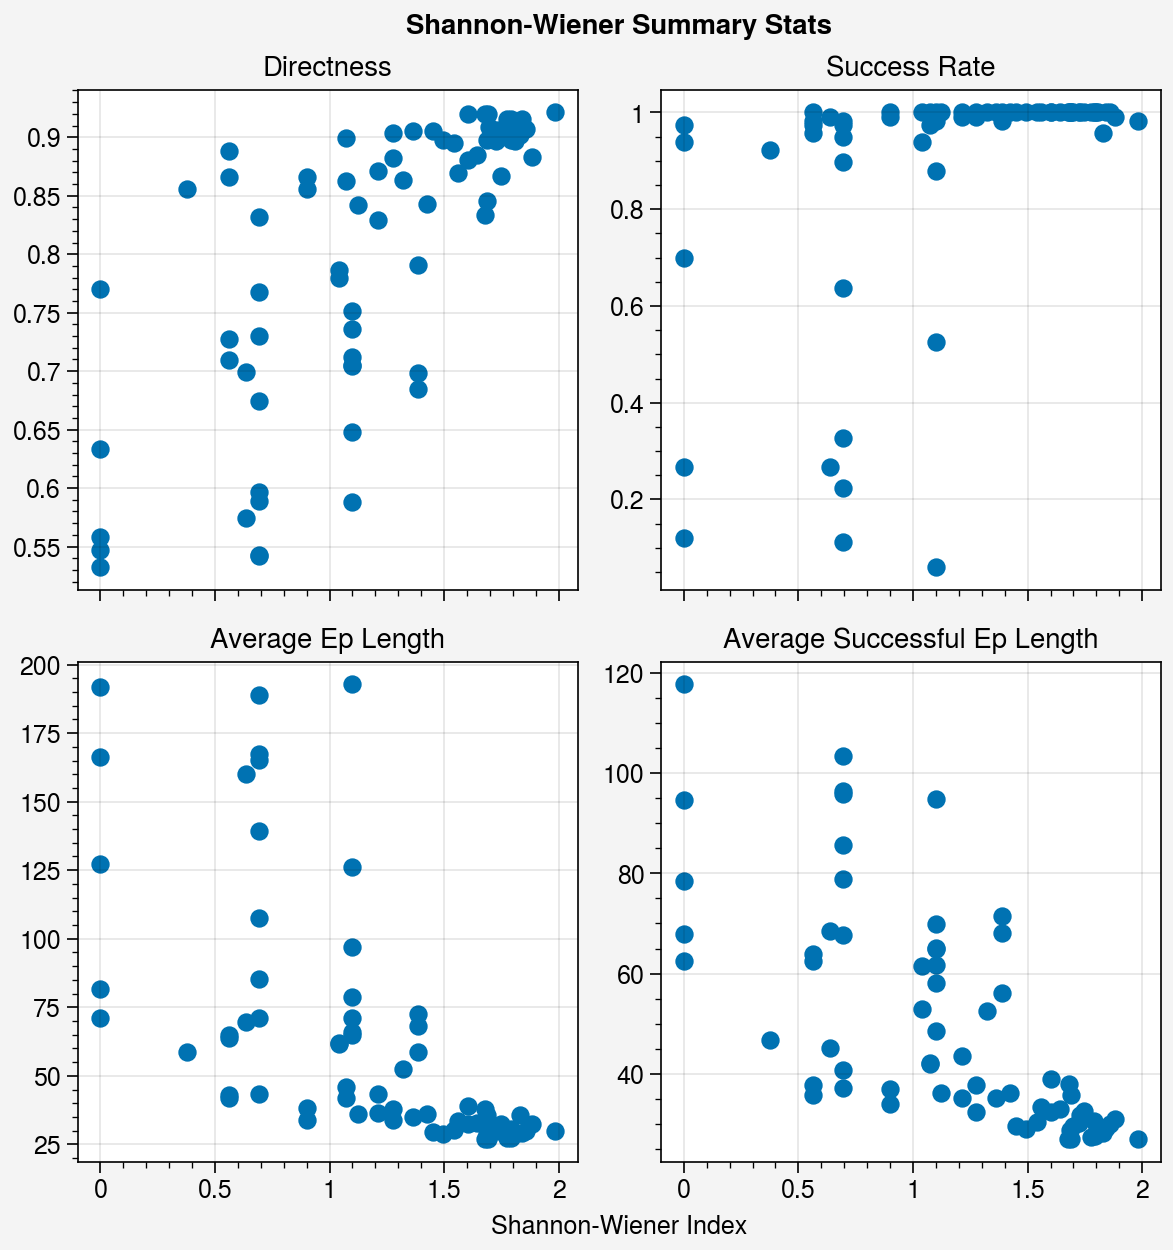

In [23]:
#Diversity measures

def count_labels(clabels, ignore_cluster=None, remove_zeros=False):
    #Convert a list of cluster labels into ratios
    cluster_counts = np.zeros(num_clusters)
    for i in range(num_clusters):
        cluster_counts[i] = np.sum(clabels == i)
        
    if ignore_cluster is not None:
        if type(ignore_cluster) == list:
            for c in ignore_cluster:
                cluster_counts[c] = 0
        elif type(ignore_cluster) == int:
            cluster_counts[ignore_cluster] = 0
    
    cluster_ratios = cluster_counts / np.sum(cluster_counts)
    
    if remove_zeros:
        cluster_ratios = cluster_ratios[cluster_ratios != 0]
        cluster_counts = cluster_counts[cluster_counts != 0]
    return cluster_counts, cluster_ratios

title = ['Directness', 'Success Rate', 'Average Ep Length', 
                 'Average Successful Ep Length']
fig, ax = pplt.subplots(ncols=2, nrows=2, sharey=False, sharex=True)
ax.format(title=title, suptitle='Shannon-Wiener Summary Stats',
         xlabel='Shannon-Wiener Index')
x = []
ys = {t: [] for t in title}

for width in widths:

    ress = results[width]
    for res in ress:
        counts, ratios = count_labels(res['cluster_labels'], remove_zeros=True)
        hprime = np.sum(-ratios * np.log(ratios))        
        
        x.append(hprime)
        ys['Directness'].append(res['directness']) 
        ys['Success Rate'].append(res['success_rate']) 
        ys['Average Ep Length'].append(res['avg_ep_len'])
        ys['Average Successful Ep Length'].append(res['avg_succ_ep_len'])
        
x = np.array(x)
for i, t in enumerate(title):
    ys[t] = np.array(ys[t])
    ax[i].scatter(x, ys[t])


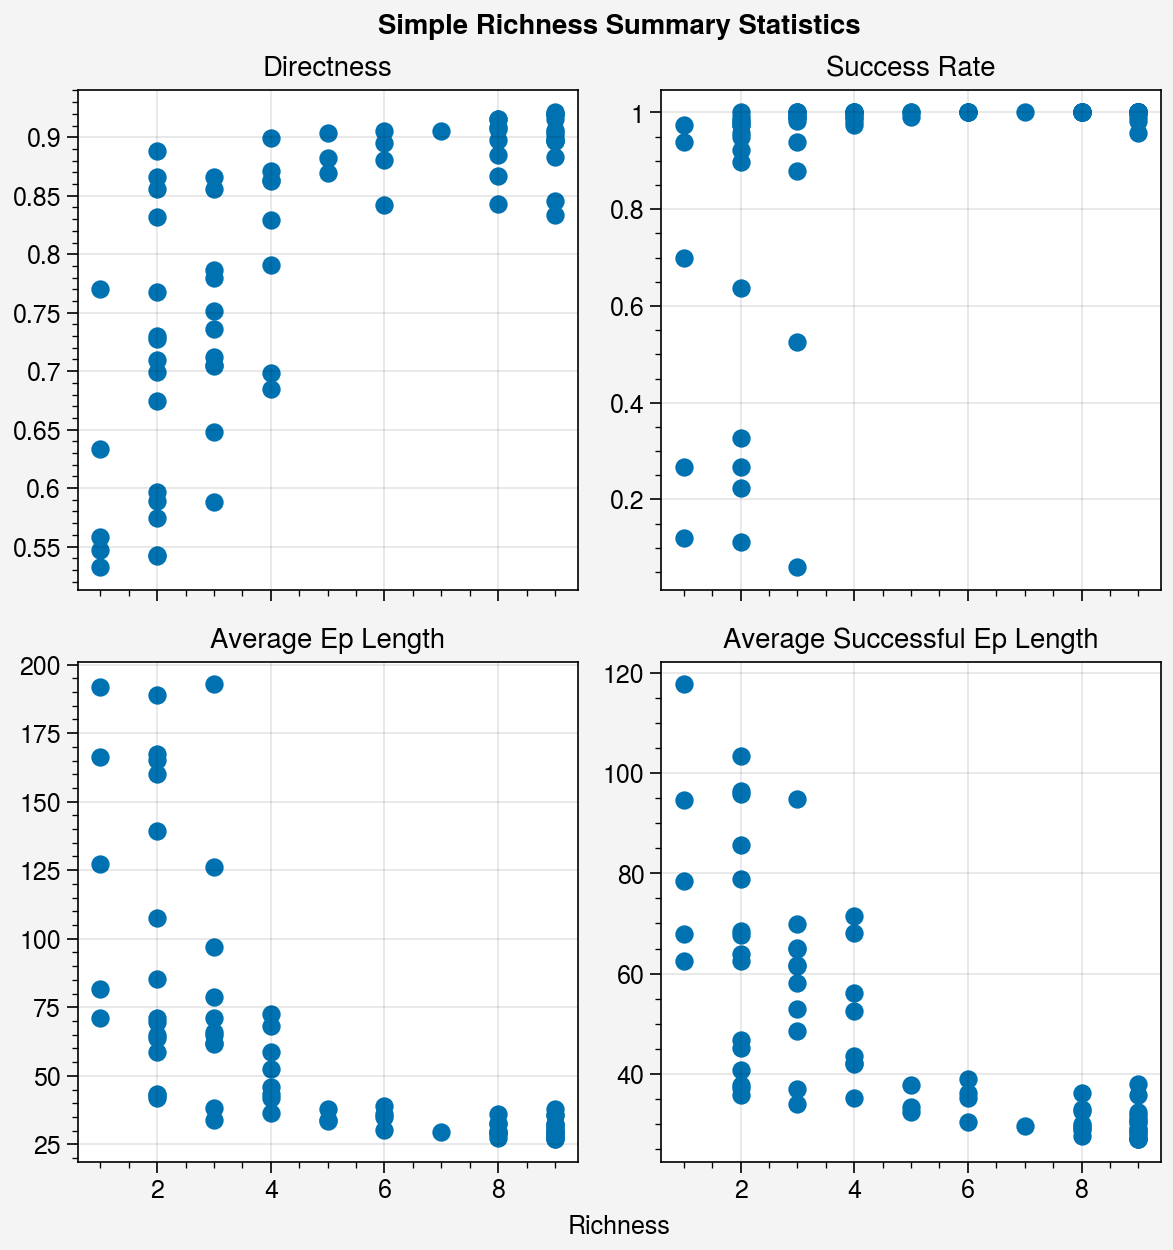

In [24]:
#Diversity measures

def count_labels(clabels, ignore_cluster=None, remove_zeros=False):
    #Convert a list of cluster labels into ratios
    cluster_counts = np.zeros(num_clusters)
    for i in range(num_clusters):
        cluster_counts[i] = np.sum(clabels == i)
        
    if ignore_cluster is not None:
        if type(ignore_cluster) == list:
            for c in ignore_cluster:
                cluster_counts[c] = 0
        elif type(ignore_cluster) == int:
            cluster_counts[ignore_cluster] = 0
    
    cluster_ratios = cluster_counts / np.sum(cluster_counts)
    
    if remove_zeros:
        cluster_ratios = cluster_ratios[cluster_ratios != 0]
        cluster_counts = cluster_counts[cluster_counts != 0]
    return cluster_counts, cluster_ratios

title = ['Directness', 'Success Rate', 'Average Ep Length', 
                 'Average Successful Ep Length']
fig, ax = pplt.subplots(ncols=2, nrows=2, sharex=True, sharey=False)
ax.format(title=title, suptitle='Simple Richness Summary Statistics',
         xlabel='Richness')
x = []
ys = {t: [] for t in title}

for width in widths:

    ress = results[width]
    for res in ress:
        counts, ratios = count_labels(res['cluster_labels'], remove_zeros=True)
        # hprime = np.sum(-ratios * np.log(ratios))
        richness = len(ratios)
        
        x.append(richness)
        ys['Directness'].append(res['directness']) 
        ys['Success Rate'].append(res['success_rate']) 
        ys['Average Ep Length'].append(res['avg_ep_len'])
        ys['Average Successful Ep Length'].append(res['avg_succ_ep_len'])
        
x = np.array(x)
for i, t in enumerate(title):
    ys[t] = np.array(ys[t])
    ax[i].scatter(x, ys[t])


### ...with coloring based on width

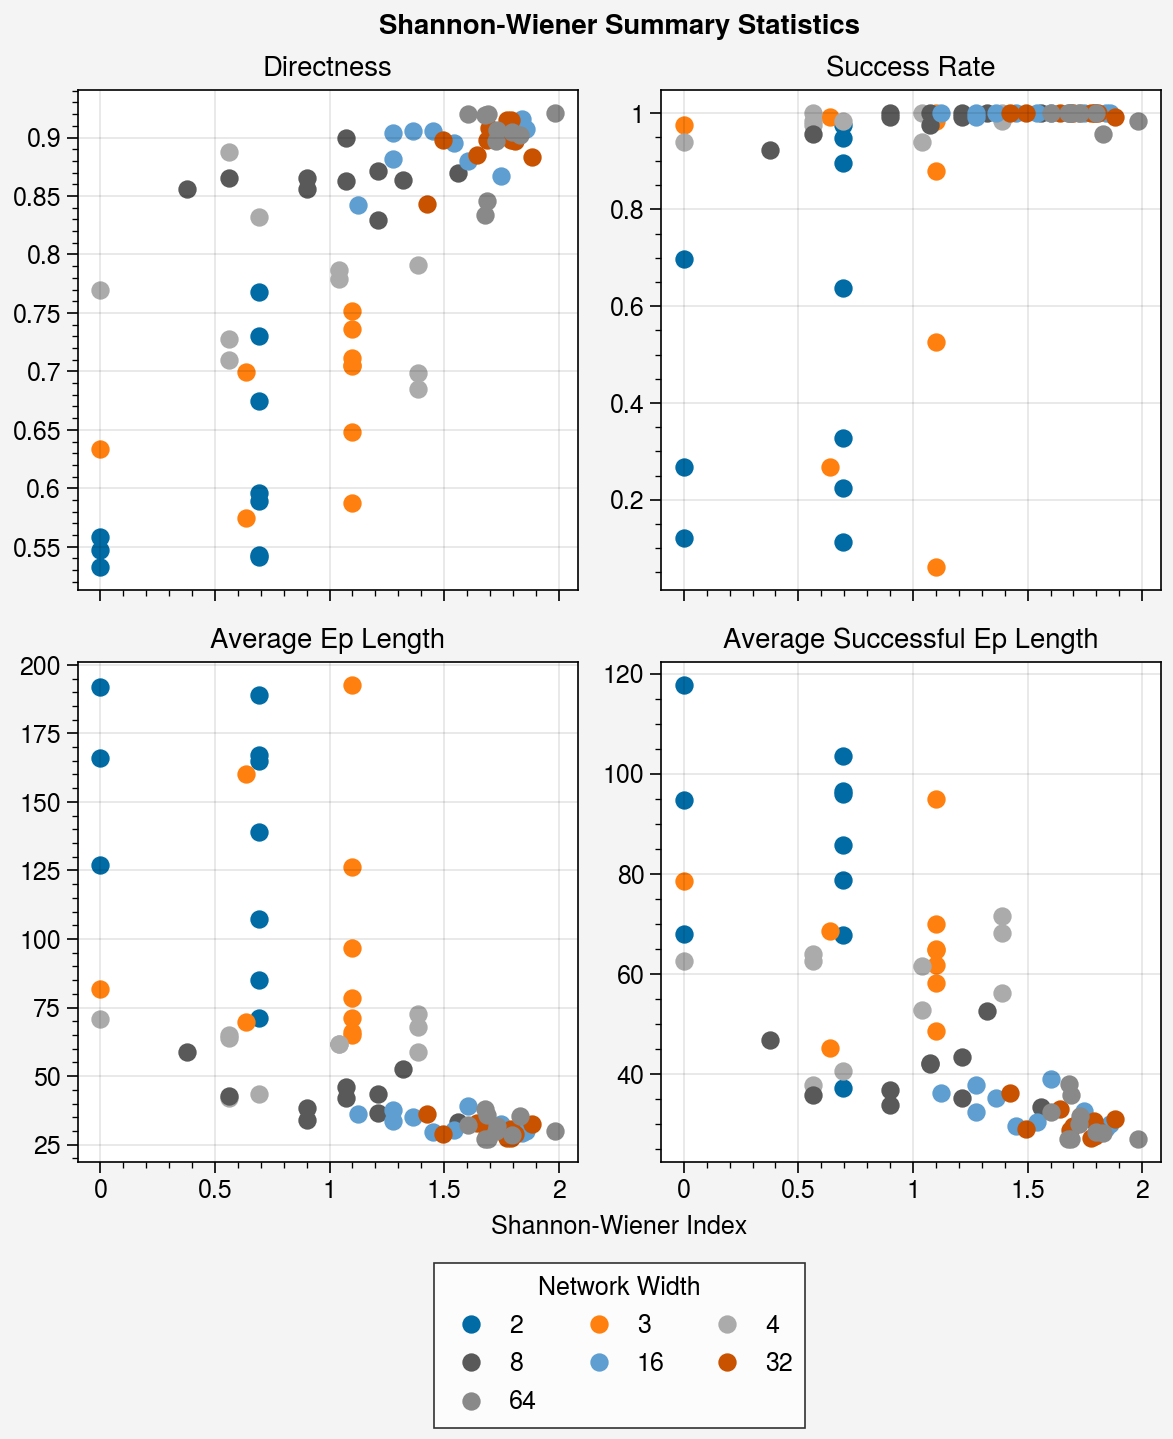

In [69]:
#Compare with simple num nodes

def count_labels(clabels, ignore_cluster=None, remove_zeros=False):
    #Convert a list of cluster labels into ratios
    cluster_counts = np.zeros(num_clusters)
    for i in range(num_clusters):
        cluster_counts[i] = np.sum(clabels == i)
        
    if ignore_cluster is not None:
        if type(ignore_cluster) == list:
            for c in ignore_cluster:
                cluster_counts[c] = 0
        elif type(ignore_cluster) == int:
            cluster_counts[ignore_cluster] = 0
    
    cluster_ratios = cluster_counts / np.sum(cluster_counts)
    
    if remove_zeros:
        cluster_ratios = cluster_ratios[cluster_ratios != 0]
        cluster_counts = cluster_counts[cluster_counts != 0]
    return cluster_counts, cluster_ratios

title = ['Directness', 'Success Rate', 'Average Ep Length', 
                 'Average Successful Ep Length']
fig, ax = pplt.subplots(nrows=2, ncols=2, sharey=False)
ax.format(title=title, suptitle='Shannon-Wiener Summary Statistics',
         xlabel='Shannon-Wiener Index')

x2 = []
ys2 = {t: [] for t in title}

color_plots = []

for n, width in enumerate(widths):
    ress = results[width]
        
    for res in ress:
        x2.append(res['shannon'])
        ys2['Directness'].append(res['directness']) 
        ys2['Success Rate'].append(res['success_rate']) 
        ys2['Average Ep Length'].append(res['avg_ep_len'])
        ys2['Average Successful Ep Length'].append(res['avg_succ_ep_len'])
        color_plots.append(n)
        
x2 = np.array(x2)
color_plots = np.array(color_plots)

x = x2.reshape(len(widths), -1)

for i, t in enumerate(title):
    y = np.array(ys2[t]).reshape(len(widths), -1)
    scatters = ax[i].scatter(x.T, y.T, cycle='tableau')

fig.legend(scatters, loc='b', labels=widths, title='Network Width')

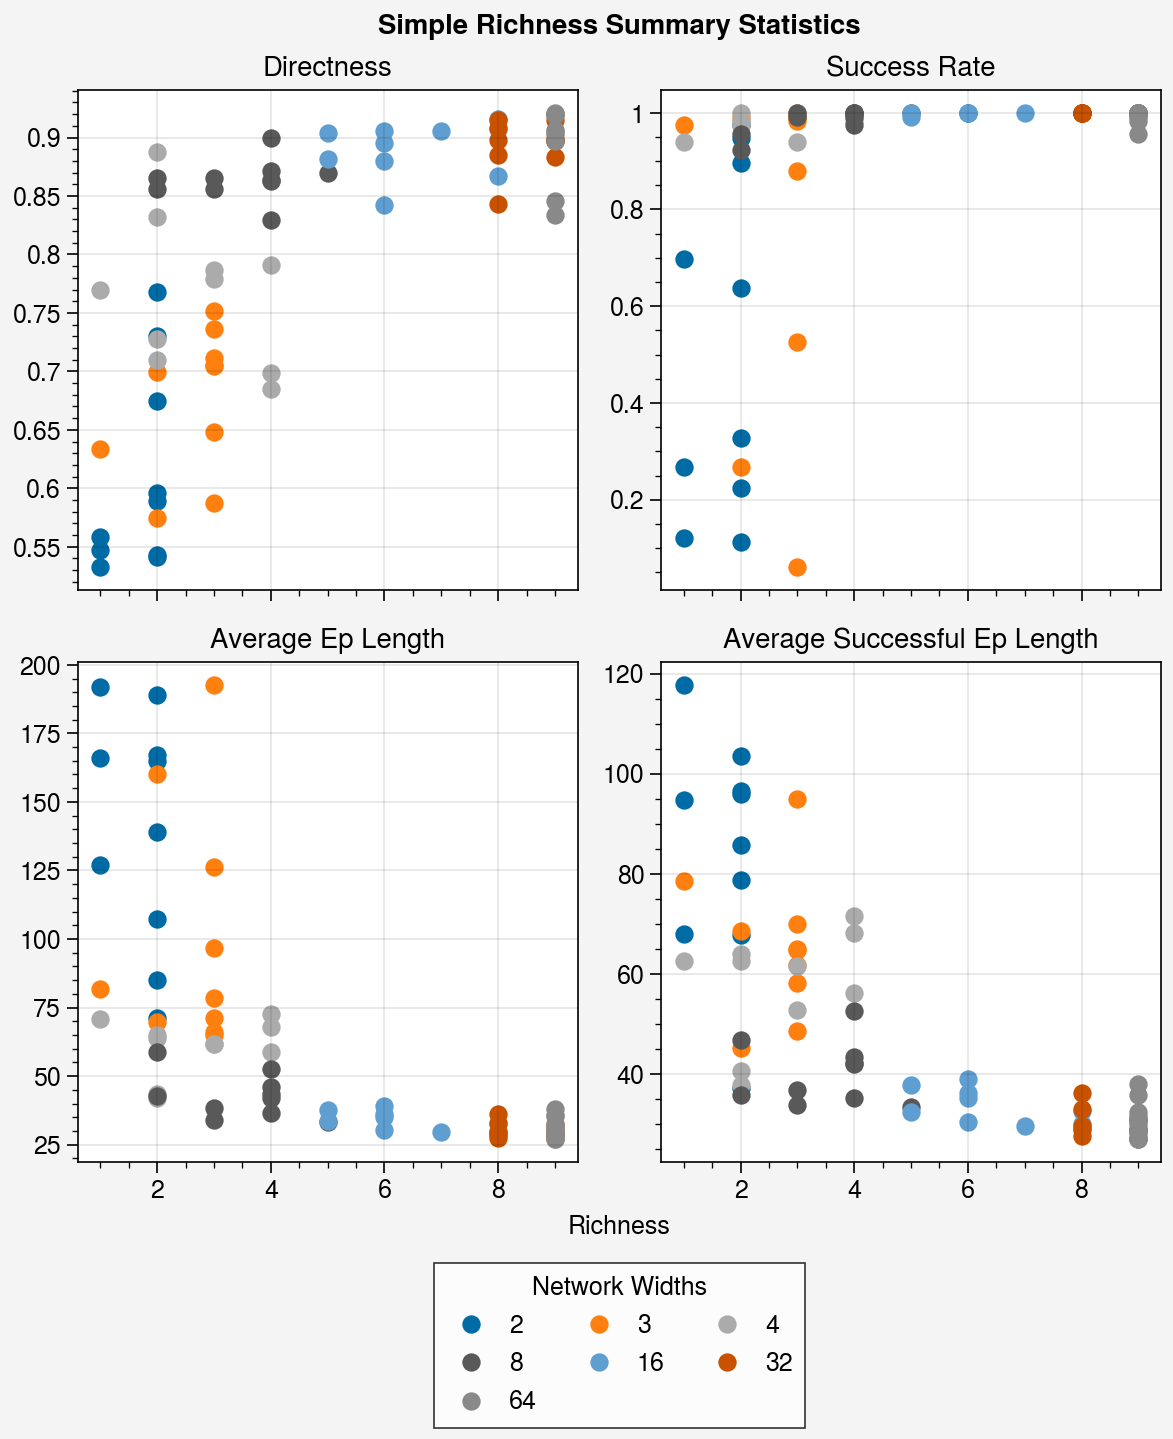

In [70]:
#Compare with simple num nodes

def count_labels(clabels, ignore_cluster=None, remove_zeros=False):
    #Convert a list of cluster labels into ratios
    cluster_counts = np.zeros(num_clusters)
    for i in range(num_clusters):
        cluster_counts[i] = np.sum(clabels == i)
        
    if ignore_cluster is not None:
        if type(ignore_cluster) == list:
            for c in ignore_cluster:
                cluster_counts[c] = 0
        elif type(ignore_cluster) == int:
            cluster_counts[ignore_cluster] = 0
    
    cluster_ratios = cluster_counts / np.sum(cluster_counts)
    
    if remove_zeros:
        cluster_ratios = cluster_ratios[cluster_ratios != 0]
        cluster_counts = cluster_counts[cluster_counts != 0]
    return cluster_counts, cluster_ratios

title = ['Directness', 'Success Rate', 'Average Ep Length', 
                 'Average Successful Ep Length']
fig, ax = pplt.subplots(nrows=2, ncols=2, sharey=False)
ax.format(title=title, suptitle='Simple Richness Summary Statistics',
         xlabel='Richness')
x2 = []
ys2 = {t: [] for t in title}

color_plots = []

for n, width in enumerate(widths):
    ress = results[width]
    for res in ress:
        counts, ratios = count_labels(res['cluster_labels'], remove_zeros=True)
        # hprime = np.sum(-ratios * np.log(ratios))
        richness = len(ratios)
        x2.append(richness)
        ys2['Directness'].append(res['directness']) 
        ys2['Success Rate'].append(res['success_rate']) 
        ys2['Average Ep Length'].append(res['avg_ep_len'])
        ys2['Average Successful Ep Length'].append(res['avg_succ_ep_len'])
        color_plots.append(n)
        
x2 = np.array(x2)
color_plots = np.array(color_plots)

x = x2.reshape(-1, len(widths))

x2 = np.array(x2)
color_plots = np.array(color_plots)

x = x2.reshape(len(widths), -1)

for i, t in enumerate(title):
    y = np.array(ys2[t]).reshape(len(widths), -1)
    scatters = ax[i].scatter(x.T, y.T, cycle='tableau')

fig.legend(scatters, loc='b', labels=widths, title='Network Widths')

# Training Progress

In [71]:
width = 16
trial = 0

data_folder = 'data/pdistal_rim_heatmap/'
data_path = data_folder + f'width{width}_checkpoint'
heatmap_path = data_folder + f'width{width}_checkpoint_hms_half'
summary_path = data_folder + f'width{width}_checkpoint_summ'

summ = pickle.load(open(summary_path, 'rb'))
hms = pickle.load(open(heatmap_path, 'rb'))

chks = list(summ[0].keys())
chks = np.sort(chks)

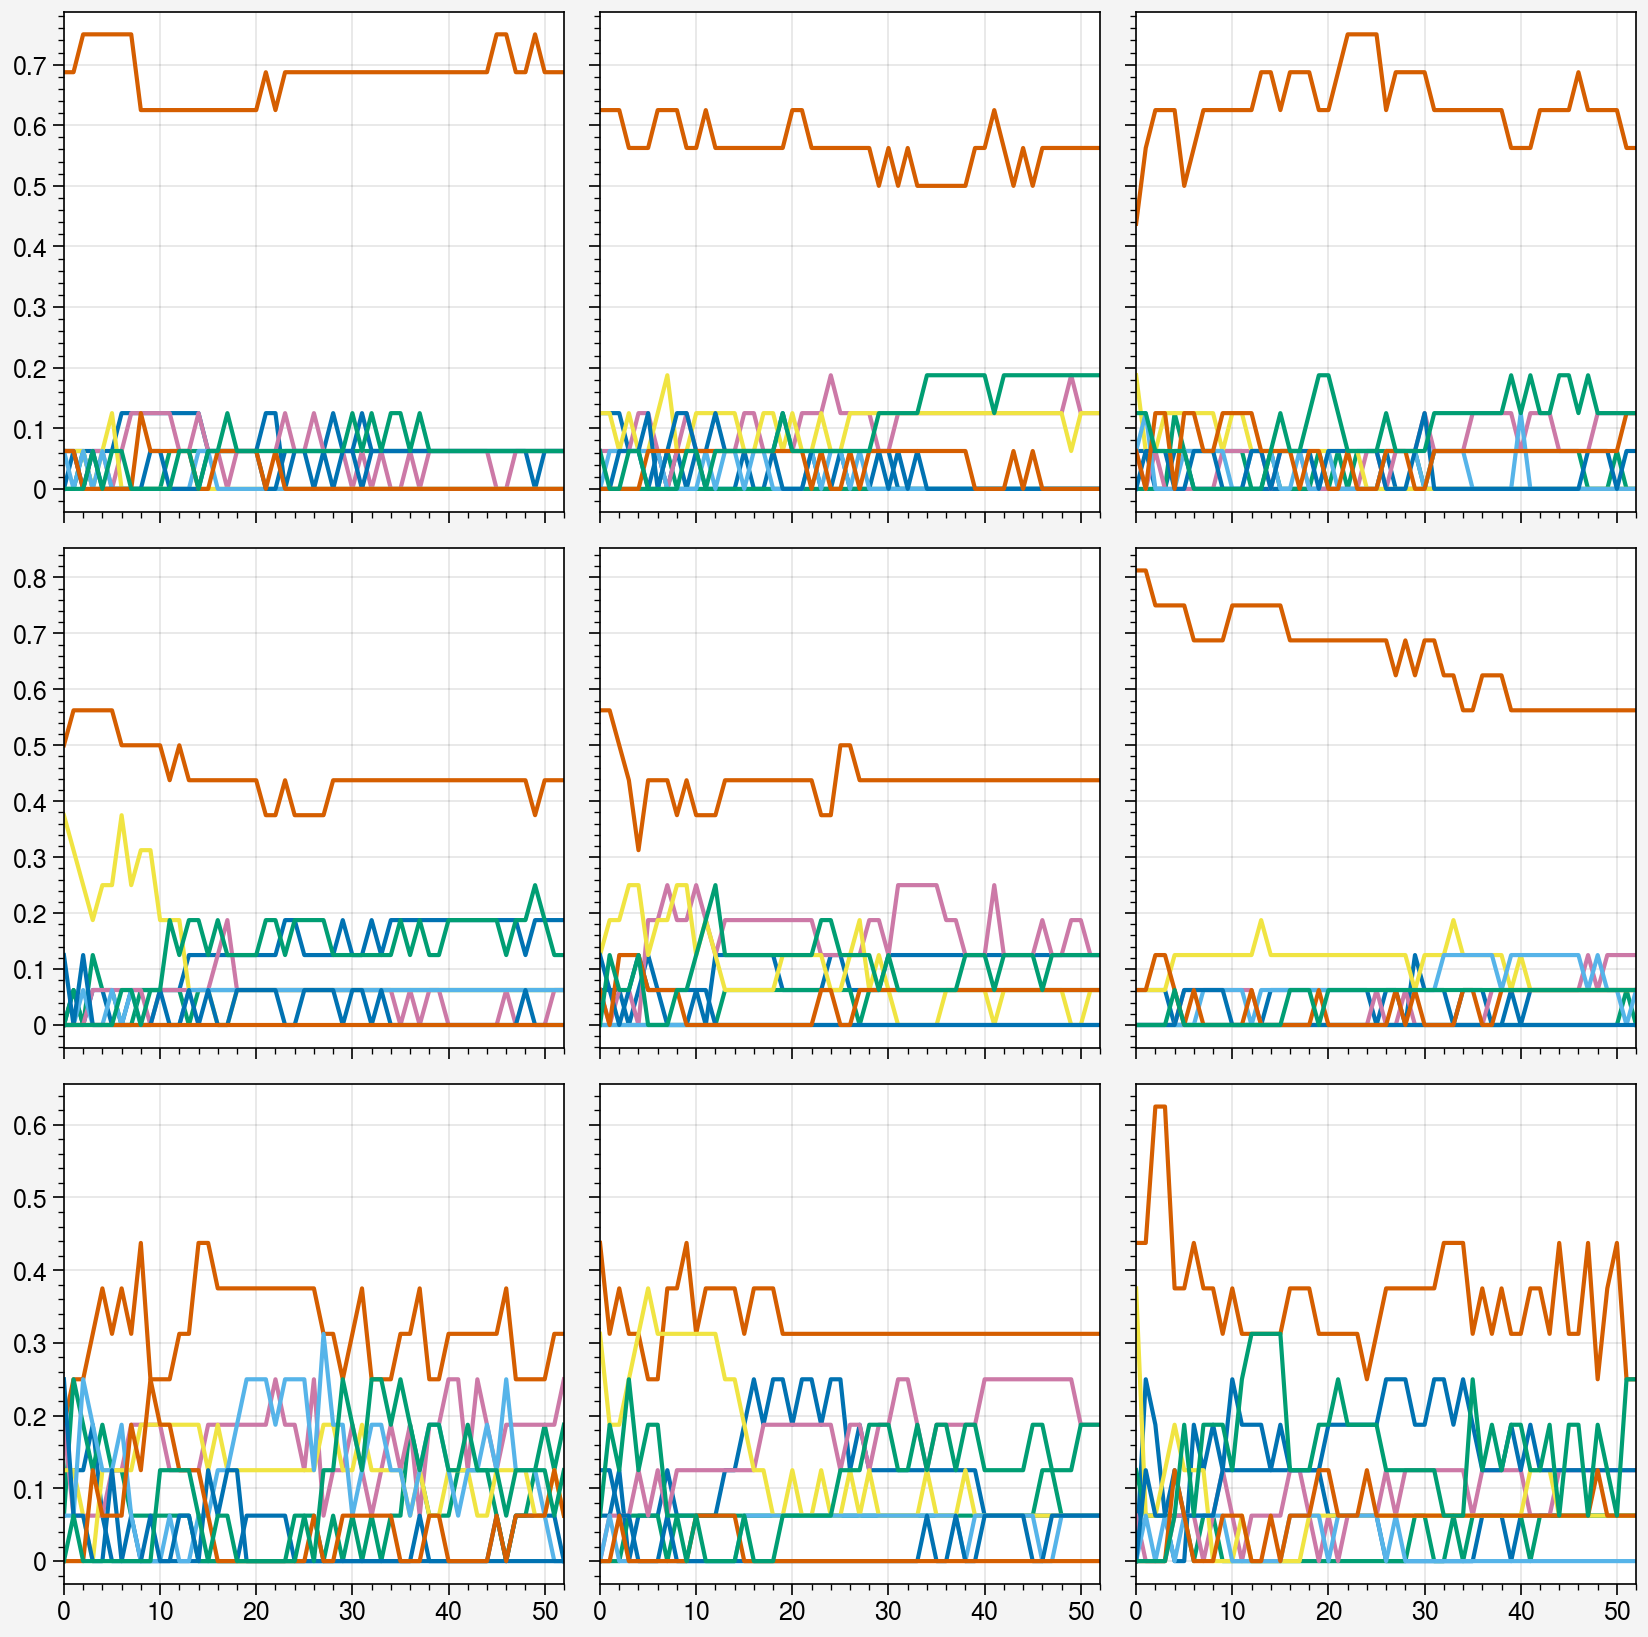

In [72]:
fig, ax = pplt.subplots(nrows=3, ncols=3)
for j in range(9):
    all_ratios = np.vstack([summ[j][chk]['cluster_ratios'] for chk in chks])
    for i in range(num_clusters):
        ax[j].plot(all_ratios[:, i])

NameError: name 'pd' is not defined

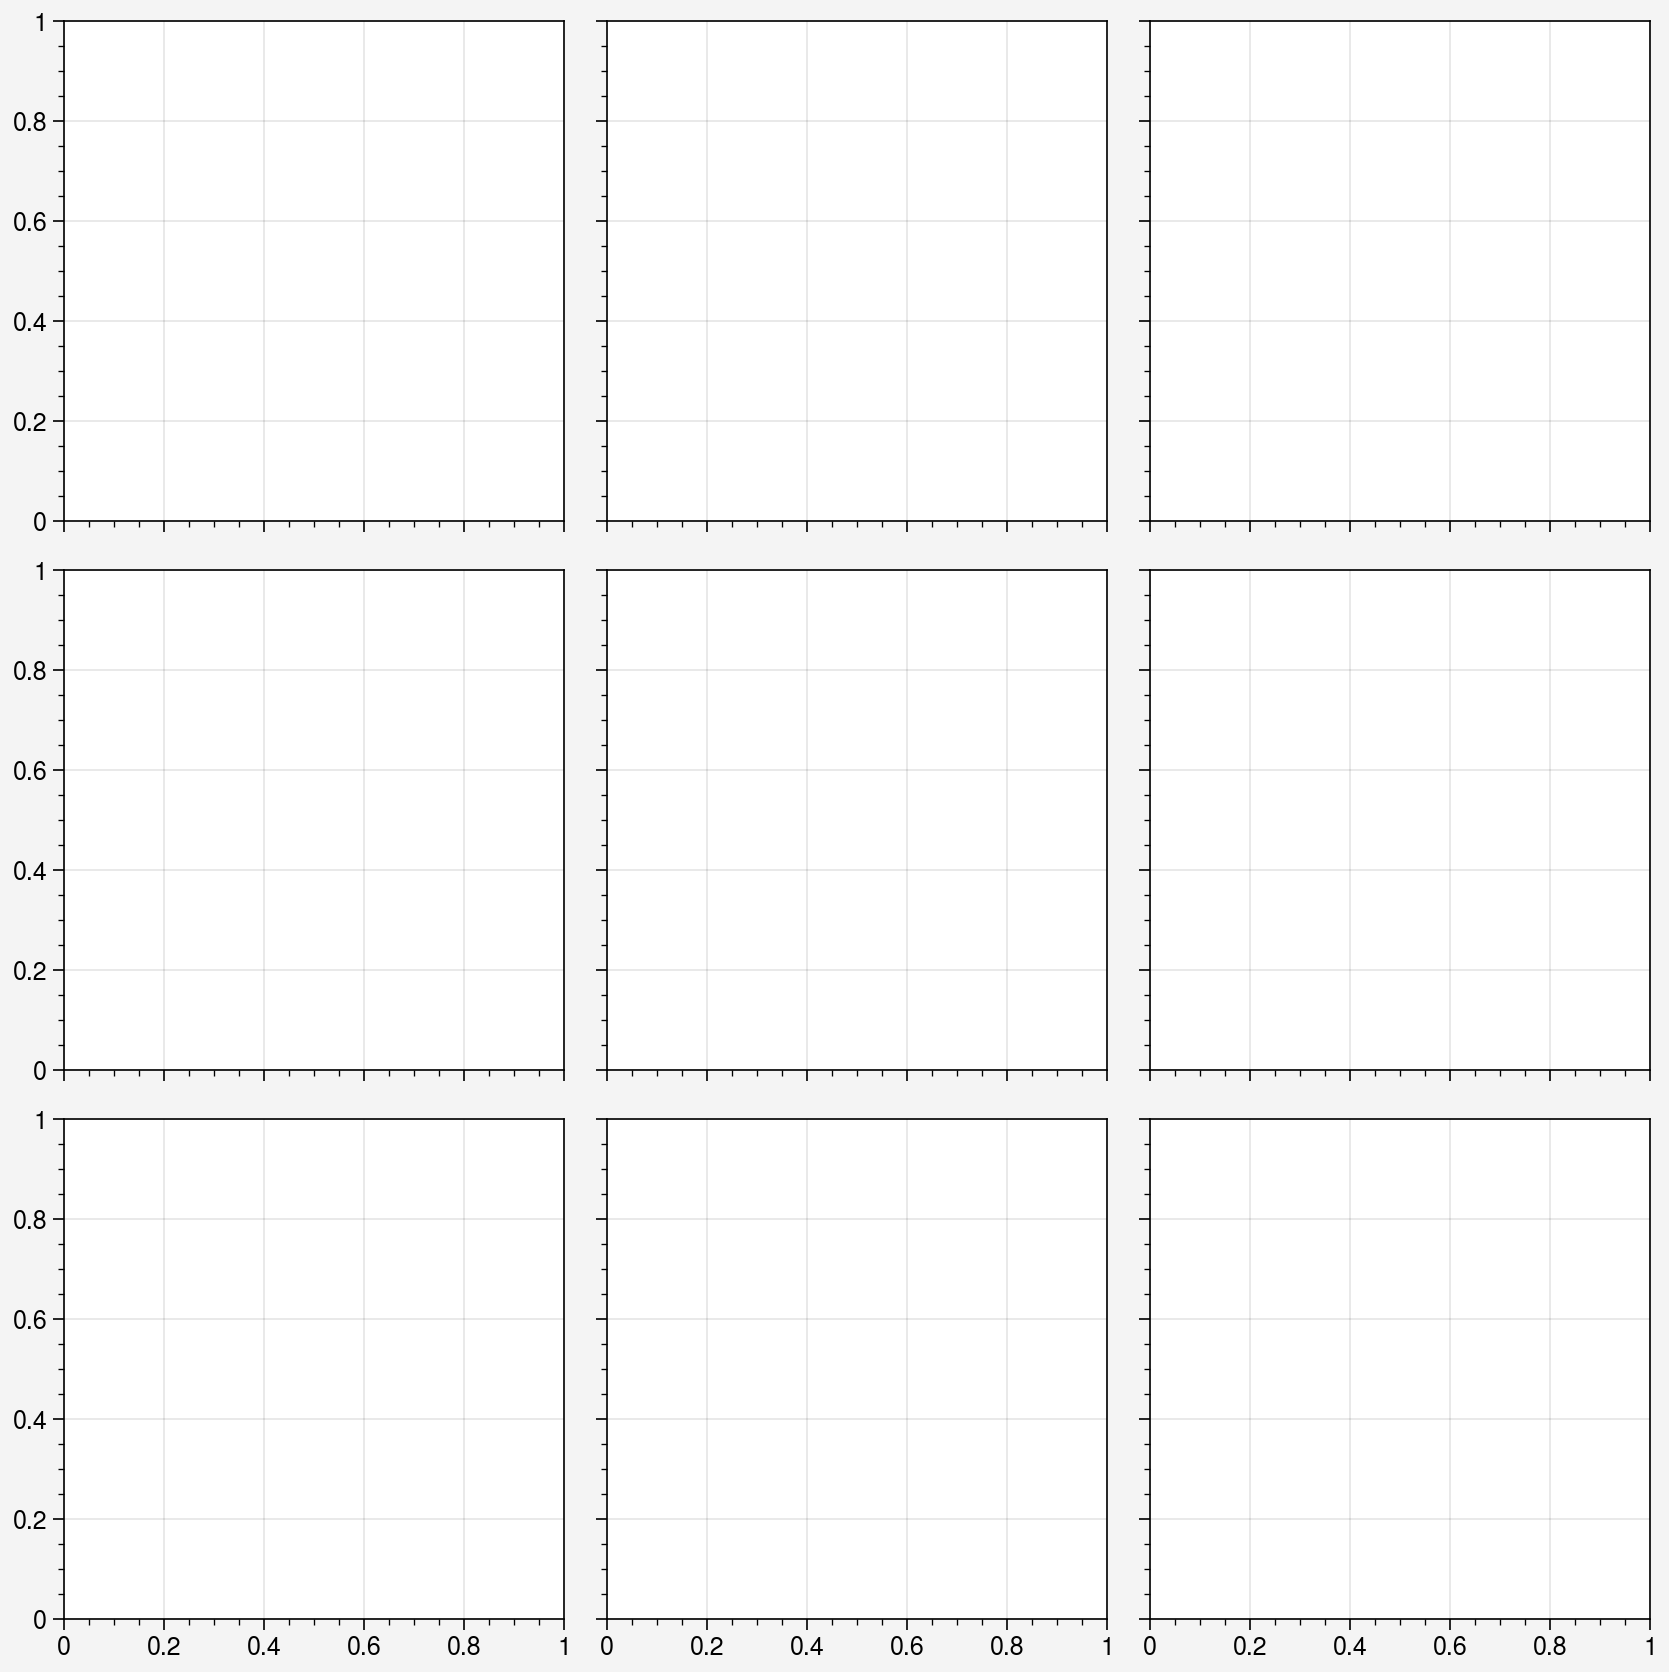

In [73]:
fig, ax = pplt.subplots(nrows=3, ncols=3)

shannons = []
directnesses = []
avg_ep_lens = []
for j in summ:
    shannon = np.vstack([summ[j][chk]['shannon'] for chk in chks]).squeeze()
    directness = np.vstack([summ[j][chk]['directness'] for chk in chks]).squeeze()
    avg_ep_len = np.vstack([summ[j][chk]['avg_ep_len'] for chk in chks]).squeeze()
    shannons.append(shannon)
    directnesses.append(directness)
    avg_ep_lens.append(avg_ep_len)


for i in range(9):
    richness = pd.Series(shannons[i]).ewm(alpha=0.3).mean()
    directness = pd.Series(directnesses[i]).ewm(alpha=0.3).mean()
    avg_ep_len = pd.Series(avg_ep_lens[i]).ewm(alpha=0.3).mean() / 200
    # richness = shannons[i]
    # directness = directnesses[i]
    ax[i].plot(richness, label='richness')
    ax[i].plot(directness, label='directness')
    ax[i].plot(avg_ep_len, label='avg_ep_len')
    
ax[0].legend(loc='ur')